In [1]:
datasetName = 'eye_AdultOmentum1_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/eye_AdultOmentum1_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,AdultOmentum_1.ACGAGCACGAGCCTGAAA,AdultOmentum_1.GAGGAGCCTTTCGCCCTC,AdultOmentum_1.ACGAGCGGACATTGCAAT,AdultOmentum_1.CCAGACAATAAATAAGGG,AdultOmentum_1.ACGAGCCGTATTGAGATC
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A2M,0,1,2,0,0
A2M-AS1,0,0,0,0,0
A2MP1,0,0,0,0,0
A4GALT,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AdultOmentum_1.ACGAGCACGAGCCTGAAA,eye,AdultOmentum,AdultOmentum,Brain death(traffic accident),Donor41,male,21 years old
AdultOmentum_1.GAGGAGCCTTTCGCCCTC,eye,AdultOmentum,AdultOmentum,Brain death(traffic accident),Donor41,male,21 years old
AdultOmentum_1.ACGAGCGGACATTGCAAT,eye,AdultOmentum,AdultOmentum,Brain death(traffic accident),Donor41,male,21 years old
AdultOmentum_1.CCAGACAATAAATAAGGG,eye,AdultOmentum,AdultOmentum,Brain death(traffic accident),Donor41,male,21 years old
AdultOmentum_1.ACGAGCCGTATTGAGATC,eye,AdultOmentum,AdultOmentum,Brain death(traffic accident),Donor41,male,21 years old


[1] Macrophage      Macrophage      Macrophage      Epithelial cell
[5] Epithelial cell
11 Levels: Dendritic cell ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


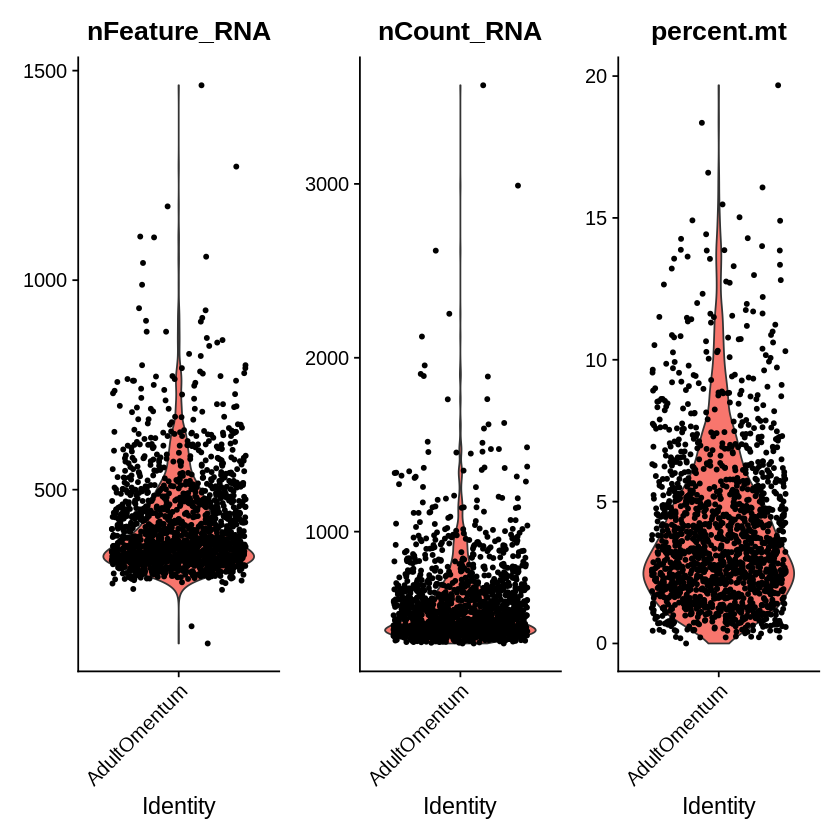

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  ITLN1, KRT18, ADIRF, PLA2G2A, KRT19, HP, CCL2, FOS, RPS18, RPS14 
	   RPL3, RPL34, RPL7, JUNB, MGP, RPL10, RPS6, IFITM3, MT-ND4, RPS27 
	   IGFBP6, MT-CYB, CTGF, AQP1, SULF1, CXADR, MT-RNR2, KRT7, TGM1, MT1M 
Negative:  FTL, TYROBP, FCER1G, LAPTM5, LIPA, CCL3, CTSS, LCP1, FTH1, CTSB 
	   AIF1, HLA-DRA, FABP4, CD74, HLA-DRB5, SRGN, SH3BGRL3, CXCL3, CD36, PLEK 
	   B2M, FTLP3, SPP1, LYZ, PLA2G7, MSR1, C1QB, C1QC, MS4A4A, ITGB2 
PC_ 2 
Positive:  ITLN1, KRT18, PLA2G2A, KRT19, ADIRF, HP, MT-ND4, MT-CO1, SLC39A8, MT-ATP6 
	   TMSB4X, RPL3, CXCL1, HAS1, RPS14, RPL34, SGK1, TGM1, RPL7, CDK2AP2 
	   AQP1, CLIC3, KRT7, UPK1B, STMN1, RPS19, MT-CO3, KLK10, ACTB, RPL10 
Negative:  LUM, DCN, APOD, MFAP4, GPX3, CXCL12, CFD, C7, COL3A1, DPT 
	   COL1A2, COL6A3, SRPX, FBLN5, COL1A1, MMP2, SERPINF1, IGFBP7, IGFBP3, HSPB6 
	   FMO2, FBN1, MFAP5, CILP, RASD1, COL6A1, MGP, POSTN, ASPN, ALDH1A1 
PC_ 3 
Positive:  IL1B, FGL2, FCN1, BCL2A1, SERPINA1, NLRP3, CXCL8, SAMSN1, LST1, HLA-DPB1 
	 

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


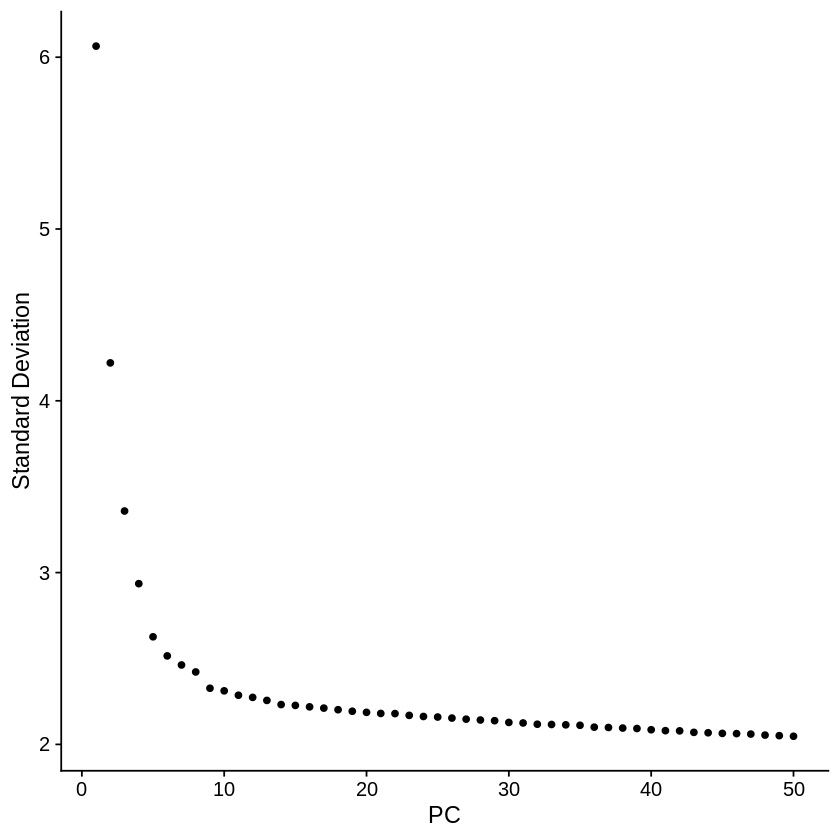

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:10:35 UMAP embedding parameters a = 0.9922 b = 1.112

20:10:35 Read 1100 rows and found 10 numeric columns

20:10:35 Using Annoy for neighbor search, n_neighbors = 30

20:10:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

20:10:35 Writing NN index file to temp file /tmp/RtmpRaeslu/file782d12de0b1c

20:10:35 Searching Annoy index using 1 thread, search_k = 3000

20:10:35 Annoy recall = 100%

20:10:36 Commencing smooth kNN distance calibration using 1 thread

20:10:36 Initializing fr

In [11]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 1)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1100
Number of edges: 38638

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6675
Number of communities: 8
Elapsed time: 0 seconds


20:10:39 UMAP embedding parameters a = 0.9922 b = 1.112

20:10:39 Read 1100 rows and found 10 numeric columns

20:10:39 Using Annoy for neighbor search, n_neighbors = 30

20:10:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

20:10:39 Writing NN index file to temp file /tmp/RtmpRaeslu/file782d145e9967

20:10:39 Searching Annoy index using 1 thread, search_k = 3000

20:10:40 Annoy recall = 100%

20:10:40 Commencing smooth kNN distance calibration using 1 thread

20:10:40 Initializing from normalized Laplacian + noise

20:10:40 Commencing optimization for 500 epochs, with 44150 positive edges

20:10:43 Optimization finished



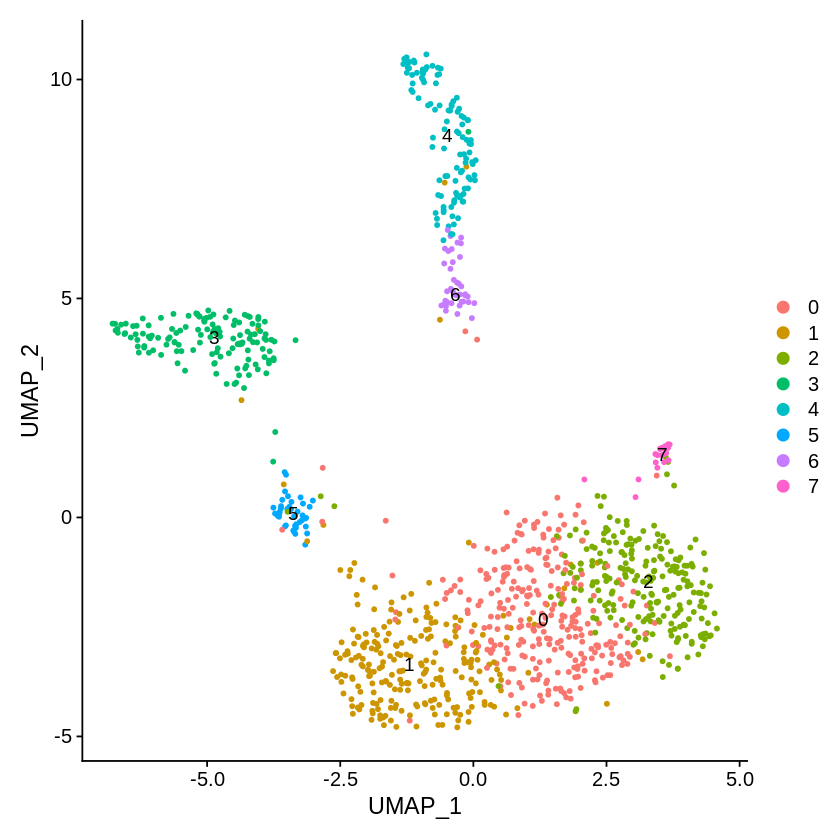

In [12]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [13]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

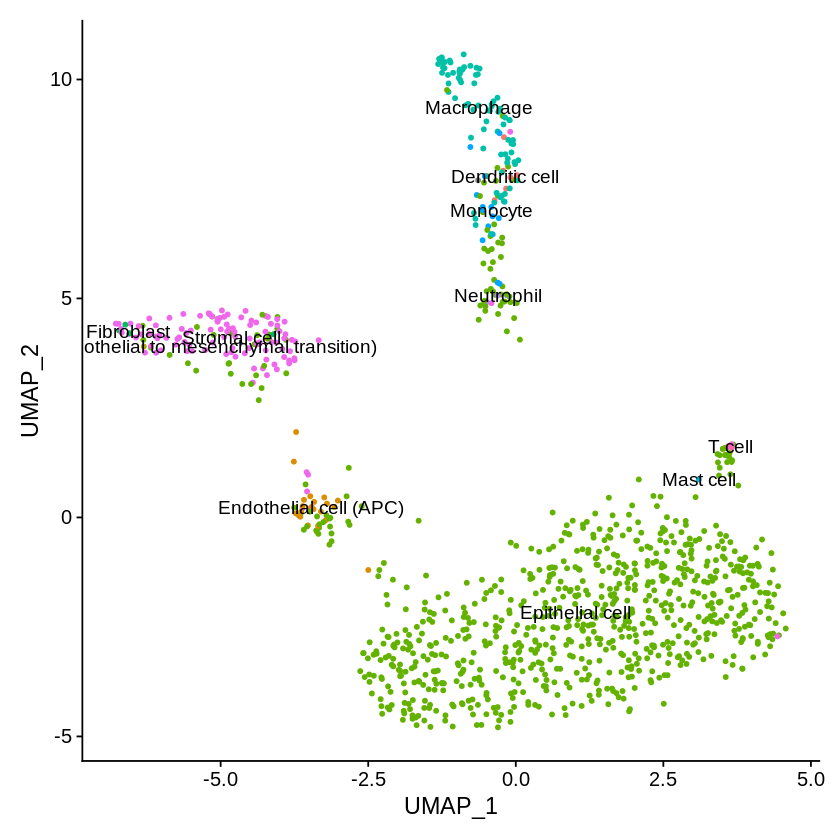

In [16]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [17]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [18]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7



In [19]:
new.cluster.ids <- c('Eye-Epithelial tissue-Mesothelial cell-KRT18', 'Eye-Epithelial tissue-Mesothelial cell-KRT18', 'Eye-Epithelial tissue-Mesothelial cell-KRT8',
                    'Eye-Connective tissue-Stromal cell-LUM', 'Eye-Connective tissue-Macrophage-CD36', 'Eye-Epithelial tissue-Endothelial cell-PLVAP',
                    'Eye-Connective tissue-Neutrophil-S100A8', 'Eye-Connective tissue-T cell-NKG7')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

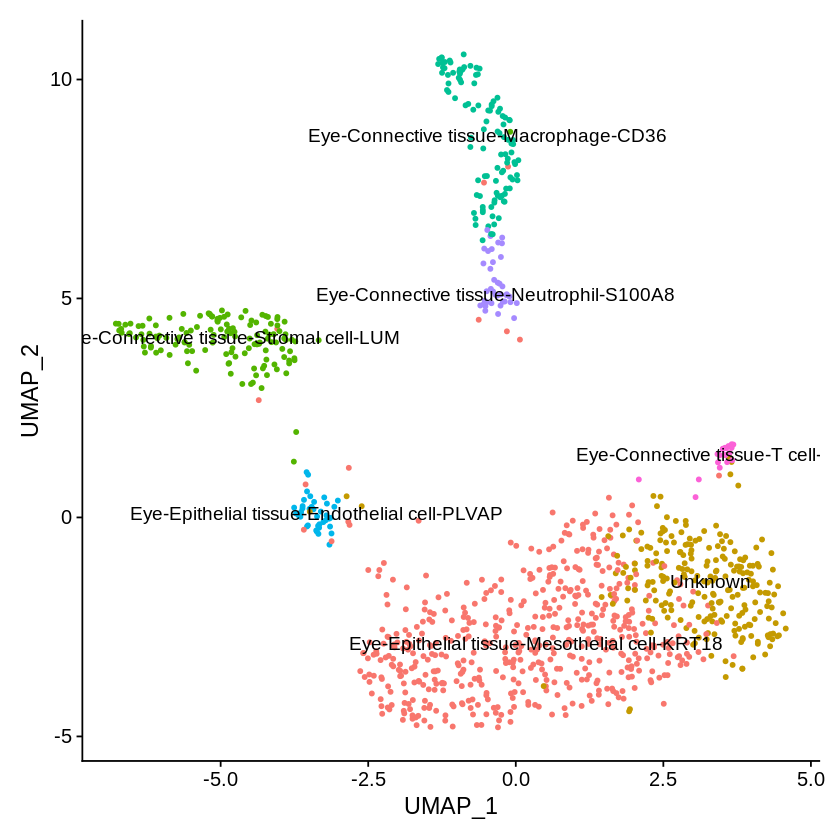

In [20]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [21]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [22]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))